# Diplodatos Kaggle Competition

In [ ]:
import sys
import os

in_colab = 'google.colab' in sys.modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import  VotingClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

### 1. Transformación de datos

...*Función para transformar los datos de train/test*

In [ ]:
# Variables generales
_funcion = 'transform_data_no_weekdays'
_path_train = '/content/drive/My Drive/train.csv'
_path_test = '/content/drive/My Drive/test.csv'

# variable que indica a las funciones de transformación de datos
# si debe remover los registros que se consideran outliers
_remover_outliers = False

In [ ]:
def dia_semana(dia):
    if dia in ['Friday', 'Monday', 'Tuesday', 'Wednesday','Thursday']:
        return 1
    else:
        return 0

In [ ]:
def transform_data(train_data_fname, test_data_fname):
    
    df_train = pd.read_csv(train_data_fname)
    df_train['is_train_set'] = 1
    df_test = pd.read_csv(test_data_fname)
    df_test['is_train_set'] = 0
    
    display(df_train.shape)
    
    
    if _remover_outliers == True:
        df_train = df_train.drop(df_train[df_train.ScanCount > 5].index)
        df_train = df_train.drop(df_train[df_train.ScanCount < -3].index)
    

    # we  get the TripType for the train set. To do that, we group by VisitNumber and
    # then we get the max (or min or avg)
    y = df_train.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType

    # we remove the TripType now, and concat training and testing data
    # the concat is done so that we have the same columns for both datasets
    # after one-hot encoding
    df_train = df_train.drop("TripType", axis=1)
    df = pd.concat([df_train, df_test])
    
    # the next three operations are the ones we have just presented in the previous lines
    
    # drop the columns we won't use (it may be good to use them somehow)
    df = df.drop(["Upc", "FinelineNumber"], axis=1)

    # one-hot encoding for the DepartmentDescription
    df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)

    # now we add the groupby values
    df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()
    
    # finally, we do one-hot encoding for the Weekday
    df = pd.get_dummies(df, columns=["Weekday"], dummy_na=True)

    # get train and test back
    df_train = df[df.is_train_set != 0]
    df_test = df[df.is_train_set == 0]
    
    
    X = df_train.drop(["is_train_set"], axis=1)
    yy = None
    XX = df_test.drop(["is_train_set"], axis=1)

    return X, y, XX, yy

In [ ]:
def transform_data_agrupado(train_data_fname, test_data_fname):
    
    df_train = pd.read_csv(train_data_fname)
    df_train['is_train_set'] = 1
    
    df_test = pd.read_csv(test_data_fname)
    df_test['is_train_set'] = 0

    print('dataset de entrada')
    display(df_train.shape)
    display(df_test.shape)


    if _remover_outliers == True:
        df_train = df_train.drop(df_train[df_train.ScanCount > 5].index)
        df_train = df_train.drop(df_train[df_train.ScanCount < -3].index)

    #0.0096 -> acumulado cerca del 98%
    df_train.TripType.replace(to_replace=[34,27,21,22,6, 20,18,28,26,29,12,31,19,4, 23,14],value=1000, inplace=True)
    #df_train.TripType.replace(to_replace=[12,31,19,4, 23,14],value=1000, inplace=True)

    
    #el grupo 41 y 43 no se clasifican para nada (se agrupan en 4143)
    df_train.TripType.replace(to_replace=[41,42,44,43],value=4143, inplace=True)

    
    # we  get the TripType for the train set. To do that, we group by VisitNumber and
    # then we get the max (or min or avg)
    y = df_train.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType

    # we remove the TripType now, and concat training and testing data
    # the concat is done so that we have the same columns for both datasets
    # after one-hot encoding
    df_train = df_train.drop("TripType", axis=1)
    df = pd.concat([df_train, df_test])
    
    # the next three operations are the ones we have just presented in the previous lines
    
    # drop the columns we won't use (it may be good to use them somehow)
    df = df.drop(["Upc", "FinelineNumber"], axis=1)
    #df = df.drop(["Upc"], axis=1)
    
    #correccion/reemplazo al nombre de la columna "MENS WEAR" por "MENSWEAR"
    df = df.replace("MENS WEAR","MENSWEAR")
    
    # one-hot encoding for the DepartmentDescription
    df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)
    
    # now we add the groupby values
    df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()
    
    # finally, we do one-hot encoding for the Weekday
    df = pd.get_dummies(df, columns=["Weekday"], dummy_na=False) # Weekday has no NAs
    df = df.set_index("VisitNumber") ### Add
    
    #convertimos las columnas al tipo de datos number y txt
    #df.FinelineNumber = df.FinelineNumber.astype('int64')
    #df.Upc = df.Upc.astype('str')

    
    #codificamos los UPC para que tengan valor numerico
    #le = LabelEncoder()
    #le.fit(df.Upc)
    #df.Upc = le.transform(df.Upc)
    
    
    #agrego columna para indicar si tipo de visita es compra o devolucion
    #df['Devolucion'] = 0
    #df.loc[df.ScanCount < 0, 'Devolucion'] = 1
    #df.loc[df.Devolucion != 1, 'Devolucion'] = 0


    #df = pd.get_dummies(df, columns=["Devolucion"], dummy_na=False) # Devolucion has no NAs
    
    # get train and test back
    df_train = df[df.is_train_set != 0]
    df_test = df[df.is_train_set == 0]
    
    X = df_train.drop(["is_train_set"], axis=1)
    yy = None
    XX = df_test.drop(["is_train_set"], axis=1)
    
    print('dataset resultante')
    display(X.shape)
    display(XX.shape)

    return X, y, XX, yy

In [ ]:
def transform_data_no_weekdays(train_data_fname, test_data_fname):
    
    df_train = pd.read_csv(train_data_fname)
    df_train['is_train_set'] = 1
    
    df_test = pd.read_csv(test_data_fname)
    df_test['is_train_set'] = 0

    print('dataset de entrada')
    display(df_train.shape)
    display(df_test.shape)
    

    if _remover_outliers == True:
        df_train = df_train.drop(df_train[df_train.ScanCount > 5].index)
        df_train = df_train.drop(df_train[df_train.ScanCount < -3].index)


    # we  get the TripType for the train set. To do that, we group by VisitNumber and
    # then we get the max (or min or avg)
    y = df_train.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType

    # we remove the TripType now, and concat training and testing data
    # the concat is done so that we have the same columns for both datasets
    # after one-hot encoding
    df_train = df_train.drop("TripType", axis=1)
    df = pd.concat([df_train, df_test])

    df['dia_semana'] =  df.Weekday.apply(lambda x: dia_semana(x))
    df = df.drop('Weekday', axis=1 )
    
    # the next three operations are the ones we have just presented in the previous lines
 
    # drop the columns we won't use (it may be good to use them somehow)
    df = df.drop(["Upc", "FinelineNumber"], axis=1)
    #df = df.drop(["Upc"], axis=1)
    
    #correccion/reemplazo al nombre de la columna "MENS WEAR" por "MENSWEAR"
    df = df.replace("MENS WEAR","MENSWEAR")
    
    # one-hot encoding for the DepartmentDescription
    df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)
    
    # now we add the groupby values
    df = df.groupby(["VisitNumber", "dia_semana"], as_index=False).sum()
    
    # finally, we do one-hot encoding for the Weekday
    df = pd.get_dummies(df, columns=["dia_semana"], dummy_na=False) # Weekday has no NAs
    df = df.set_index("VisitNumber") ### Add
    
    #convertimos las columnas al tipo de datos number y txt
    #df.FinelineNumber = df.FinelineNumber.astype('int64')
    #df.Upc = df.Upc.astype('str')

    
    #codificamos los UPC para que tengan valor numerico
    #le = LabelEncoder()
    #le.fit(df.Upc)
    #df.Upc = le.transform(df.Upc)
    
    
    #agrego columna para indicar si tipo de visita es compra o devolucion
    #df['Devolucion'] = 0
    #df.loc[df.ScanCount < 0, 'Devolucion'] = 1
    #df.loc[df.Devolucion != 1, 'Devolucion'] = 0
    #df = pd.get_dummies(df, columns=["Devolucion"], dummy_na=False) # Devolucion has no NAs
    
    # get train and test back
    df_train = df[df.is_train_set != 0]
    df_test = df[df.is_train_set == 0]
    
    X = df_train.drop(["is_train_set"], axis=1)
    yy = None
    XX = df_test.drop(["is_train_set"], axis=1)
    
    print('dataset resultante')
    display(X.shape)
    display(XX.shape)

    return X, y, XX, yy

In [ ]:
def transform_data_agrupado_no_weekdays(train_data_fname, test_data_fname):
    
    df_train = pd.read_csv(train_data_fname)
    df_train['is_train_set'] = 1
    
    df_test = pd.read_csv(test_data_fname)
    df_test['is_train_set'] = 0

    print('dataset de entrada')
    display(df_train.shape)
    display(df_test.shape)

    if _remover_outliers == True:
        df_train = df_train.drop(df_train[df_train.ScanCount > 5].index)
        df_train = df_train.drop(df_train[df_train.ScanCount < -3].index)

    #0.0096 -> acumulado cerca del 98%   
    df_train.TripType.replace(to_replace=[34,27,21,22,6, 20,18,28,26,29,12,31,19,4, 23,14],value=1000, inplace=True)

    #el grupo 41 , 42 y 43 no se clasifican para nada (se agrupan en 4143)
    df_train.TripType.replace(to_replace=[41,42,43],value=414243, inplace=True)


    # we  get the TripType for the train set. To do that, we group by VisitNumber and
    # then we get the max (or min or avg)
    y = df_train.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType

    # we remove the TripType now, and concat training and testing data
    # the concat is done so that we have the same columns for both datasets
    # after one-hot encoding
    df_train = df_train.drop("TripType", axis=1)
    df = pd.concat([df_train, df_test])

    df['dia_semana'] =  df.Weekday.apply(lambda x: dia_semana(x))
    df = df.drop('Weekday', axis=1 )
    
    # the next three operations are the ones we have just presented in the previous lines
 
    # drop the columns we won't use (it may be good to use them somehow)
    df = df.drop(["Upc", "FinelineNumber"], axis=1)
    #df = df.drop(["Upc"], axis=1)
    
    #correccion/reemplazo al nombre de la columna "MENS WEAR" por "MENSWEAR"
    df = df.replace("MENS WEAR","MENSWEAR")
    
    # one-hot encoding for the DepartmentDescription
    df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)
    
    # now we add the groupby values
    df = df.groupby(["VisitNumber", "dia_semana"], as_index=False).sum()
    
    # finally, we do one-hot encoding for the Weekday
    df = pd.get_dummies(df, columns=["dia_semana"], dummy_na=False) # Weekday has no NAs
    df = df.set_index("VisitNumber") ### Add
    
    #convertimos las columnas al tipo de datos number y txt
    #df.FinelineNumber = df.FinelineNumber.astype('int64')
    #df.Upc = df.Upc.astype('str')

    
    #codificamos los UPC para que tengan valor numerico
    #le = LabelEncoder()
    #le.fit(df.Upc)
    #df.Upc = le.transform(df.Upc)
    
    
    #agrego columna para indicar si tipo de visita es compra o devolucion
    #df['Devolucion'] = 0
    #df.loc[df.ScanCount < 0, 'Devolucion'] = 1
    #df.loc[df.Devolucion != 1, 'Devolucion'] = 0
    #df = pd.get_dummies(df, columns=["Devolucion"], dummy_na=False) # Devolucion has no NAs
    
    # get train and test back
    df_train = df[df.is_train_set != 0]
    df_test = df[df.is_train_set == 0]
    
    X = df_train.drop(["is_train_set"], axis=1)
    yy = None
    XX = df_test.drop(["is_train_set"], axis=1)
    
    print('dataset resultante')
    display(X.shape)
    display(XX.shape)

    return X, y, XX, yy


In [ ]:
def get_datos(funcion, train_data_fname, test_data_fname):
    if funcion == 'transform_data':
        return transform_data(train_data_fname, test_data_fname)
    elif funcion == 'transform_data_agrupado':
        return transform_data_agrupado(train_data_fname, test_data_fname)
    elif funcion == 'transform_data_no_weekdays':
        return transform_data_no_weekdays(train_data_fname, test_data_fname)
    elif funcion == 'transform_data_agrupado_no_weekdays':
        return transform_data_agrupado_no_weekdays(train_data_fname, test_data_fname)
    else:
        return None, None, None, None


En al funcion **"transform_data_agrupado"** se agruparon algunas categorias en 1000 y 4143. Se Analizó la participación de cada grupo en el total de registros realizando un pareto con el %acumulado y se unificaron en la categoria 1000 0.2% de los datos. Para la categoria 4143 se agruparon las categorías 41 y 43 debido que el reporte de clasificación para todos los modelos arrojaba un 0% en recall.




En el análisis de datos, se puede ver el que los datos esta desbalanceados y existen registros que se pueden considerar outliers. 

Se definió una variable para realizar pruebas activando o no la eliminacion de estos registros


## Analisis de datos

In [ ]:
if in_colab:
    df_ori = pd.read_csv(_path_train)
else:
     df_ori = pd.read_csv(_path_train)

df_ori_sort = df_ori.groupby('DepartmentDescription')['ScanCount'].count()
df_ori_sort.reset_index()
df_ori_sort = df_ori_sort.sort_values(axis=0, ascending=False)

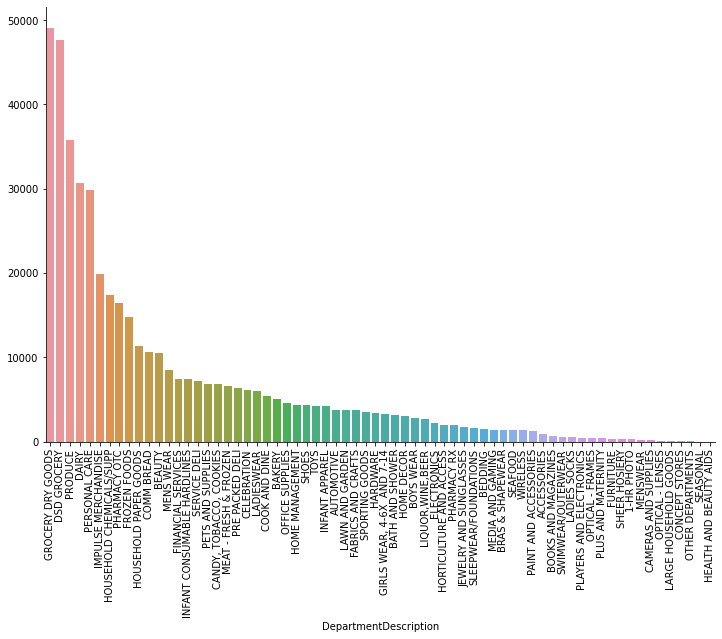

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x=df_ori_sort.index, y=df_ori_sort.values)
plt.xticks(rotation=90)
sns.despine()
plt.show()


Los datos también se encuentran desbalanceados a nivel de departamentos

### Analisis de outliers

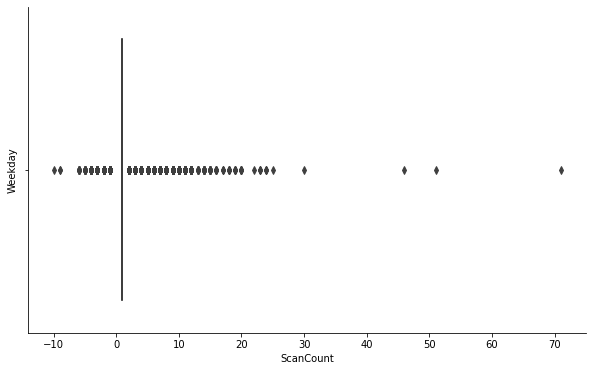

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='ScanCount',y='Weekday',data=df_ori)
sns.boxplot(x=df_ori.ScanCount)
sns.despine()

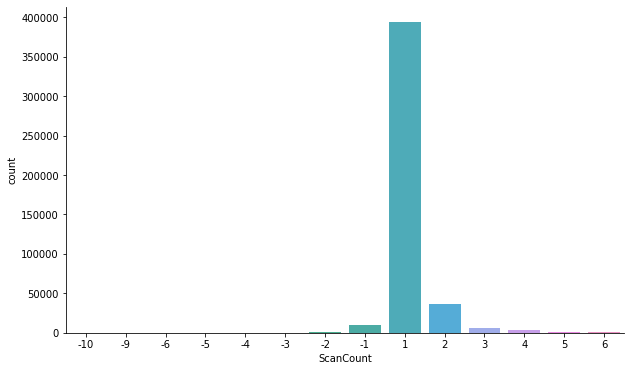

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(df_ori[df_ori.ScanCount<=6].ScanCount)
sns.despine()

La gran concentración de registro se encuentra entre 1 y 5 compras y entre 1 y 4 devoluciones.

Se podría considerar estos registros como outliers para el proceso de clasificación

In [ ]:
df_ori[df_ori.ScanCount>5]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
173,40,152,Friday,4.178900e+09,14,GROCERY DRY GOODS,3105.0
469,33,346,Friday,7.874209e+09,9,HOUSEHOLD PAPER GOODS,6030.0
470,33,346,Friday,7.874211e+09,9,HOUSEHOLD PAPER GOODS,6020.0
576,35,394,Friday,4.510006e+09,7,DSD GROCERY,2323.0
913,40,592,Friday,7.874211e+09,7,GROCERY DRY GOODS,2839.0
...,...,...,...,...,...,...,...
449152,24,189910,Sunday,7.600137e+09,9,HOME DECOR,5547.0
449752,40,190123,Sunday,1.500003e+09,12,INFANT CONSUMABLE HARDLINES,3153.0
450101,25,190210,Sunday,1.590013e+09,6,PRE PACKED DELI,7501.0
452158,32,190942,Sunday,6.657211e+10,7,BATH AND SHOWER,1507.0


In [ ]:
df_ori[df_ori.ScanCount<-4]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
3094,999,1705,Friday,8.972604e+09,-5,SPORTING GOODS,610.0
7706,999,3814,Friday,7.450991e+09,-5,AUTOMOTIVE,7000.0
20457,999,9081,Saturday,NaN,-6,NaN,NaN
46366,999,18397,Sunday,4.133104e+09,-6,GROCERY DRY GOODS,4292.0
70992,999,29397,Tuesday,7.535312e+09,-5,OFFICE SUPPLIES,3550.0
101685,999,43960,Friday,8.752170e+10,-6,COOK AND DINE,1207.0
114134,27,49731,Saturday,2.911940e+10,-5,HORTICULTURE AND ACCESS,3735.0
117407,999,50902,Saturday,9.853000e+03,-6,BAKERY,5040.0
152043,24,63952,Monday,7.644086e+09,-5,HOME MANAGEMENT,1200.0
190298,35,80542,Wednesday,8.768400e+09,-9,DSD GROCERY,4624.0


...Cargamos los datos en los dataframe de train, y Test

In [ ]:

if in_colab:
    #X, y, XX, yy = transform_data("/content/drive/My Drive/train.csv", "/content/drive/My Drive/test.csv")
    X, y, XX, yy = get_datos(_funcion, _path_train, _path_test)
else:
    #X, y, XX, yy = transform_data("../data/train.csv", "../data/test.csv")
    X, y, XX, yy = get_datos(_funcion, _path_train, _path_test)



dataset de entrada


(453411, 8)

(193643, 7)

dataset resultante


(67029, 71)

(28645, 71)

### 2. Datos de Train y Valid
...*Separamos los datos en train y valid*

In [ ]:
#Separamos 85% train y 15% valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

...*Normalización de datos*

In [ ]:
# Normalizamos los datos

ss = StandardScaler()
ss.fit(X_train)
ss.fit(X_valid)
ss.fit(XX)

X_train_norm = ss.transform(X_train)
X_valid_norm = ss.transform(X_valid)
X_test_norm = ss.transform(XX)

### 3. Modelos de Clasificación (hiperparametros por defecto)

#### 3.1 KNeighborsClassifier

In [ ]:
#instancia del modelo
knc = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knc = knc.fit(X_train_norm, y_train)

In [ ]:
y_pred_train_knc = knc.predict(X_train_norm)
y_pred_valid_knc = knc.predict(X_valid_norm)

##### Accuarcy KNeighborsClassifier

In [ ]:
display("Presición Train:",accuracy_score(y_train,y_pred_train_knc ) )
display("Presición Valid:", accuracy_score(y_valid,y_pred_valid_knc ) )

'Presición Train:'

0.6613593111115298

'Presición Valid:'

0.5666239590006407

##### Matriz de confusión (validación) KNeighborsClassifier

In [ ]:
pd.crosstab(y_valid,y_pred_valid_knc , rownames=['True'], colnames=['Predicción'], margins=True)


Predicción,3,5,7,8,9,15,21,24,25,27,30,32,33,34,35,36,37,38,39,40,41,42,43,44,999,All
True,,,,,,,,,,,,,,,,,,,,,,,,,,
3,373,0,1,2,10,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,7,395
5,3,437,2,21,18,0,0,3,0,1,2,0,0,2,3,5,3,0,8,0,0,0,1,1,3,513
7,0,1,448,66,17,0,0,0,2,1,1,0,0,1,0,0,11,9,31,0,0,0,0,0,4,592
8,4,34,90,997,67,1,0,4,0,0,2,9,4,4,12,9,4,5,6,0,0,0,0,0,13,1265
9,2,1,5,32,799,0,6,24,26,6,19,9,0,0,1,0,0,0,0,0,0,0,0,0,40,970
15,1,0,2,16,30,32,1,0,0,0,0,0,2,0,0,0,1,2,6,2,0,1,1,0,0,97
21,1,0,0,1,22,3,51,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,83
24,8,2,0,7,96,0,3,129,3,0,0,0,0,0,1,1,2,1,9,1,1,0,0,0,11,275
25,3,5,6,6,97,2,1,3,229,0,9,0,0,0,0,1,0,0,5,0,0,1,0,0,10,378


##### Reporte de Clasificación KNN (validación)

In [ ]:
print(classification_report(y_valid, y_pred_valid_knc))

              precision    recall  f1-score   support

           3       0.86      0.94      0.90       395
           5       0.74      0.85      0.79       513
           7       0.48      0.76      0.59       592
           8       0.61      0.79      0.69      1265
           9       0.45      0.82      0.58       970
          15       0.45      0.33      0.38        97
          21       0.53      0.61      0.57        83
          24       0.47      0.47      0.47       275
          25       0.58      0.61      0.59       378
          27       0.43      0.51      0.47        81
          30       0.29      0.25      0.27       107
          32       0.66      0.63      0.64       215
          33       0.52      0.46      0.49       159
          34       0.47      0.45      0.46        77
          35       0.38      0.30      0.33       213
          36       0.53      0.41      0.46       305
          37       0.54      0.39      0.45       330
          38       0.37    

#### 3.2 Regresión Logística

In [ ]:
#instancia del modelo
lr = LogisticRegression(random_state=42)
lr.fit(X_train_norm, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred_train_lr = knc.predict(X_train_norm)
y_pred_valid_lr = knc.predict(X_valid_norm)

##### Accuarcy Regresión Logística

In [ ]:
display("Presición Train:",accuracy_score(y_train,y_pred_train_lr ) )
display("Presición Valid:", accuracy_score(y_valid,y_pred_valid_lr ) )

'Presición Train:'

0.6613593111115298

'Presición Valid:'

0.5666239590006407

##### Matriz de confusión (validación) KNeighborsClassifier

In [ ]:
pd.crosstab(y_valid,y_pred_valid_lr , rownames=['True'], colnames=['Predicción'], margins=True)

##### Reporte de Clasificación Regresión Logística (validación)

In [ ]:
print(classification_report(y_valid, y_pred_valid_lr))

              precision    recall  f1-score   support

           3       0.85      0.94      0.89       388
           4       0.15      0.18      0.16        34
           5       0.66      0.78      0.72       494
           6       0.53      0.86      0.65       141
           7       0.52      0.76      0.62       614
           8       0.61      0.81      0.69      1258
           9       0.42      0.75      0.54       992
          12       0.08      0.03      0.05        31
          14       0.00      0.00      0.00         1
          15       0.43      0.21      0.28        97
          18       0.41      0.34      0.37        65
          19       0.26      0.25      0.26        40
          20       0.48      0.43      0.45        67
          21       0.47      0.51      0.49        77
          22       0.50      0.44      0.47       108
          23       0.21      0.21      0.21        14
          24       0.47      0.55      0.51       273
          25       0.62    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 3.3 Naive Bayes

In [ ]:
#instancia del modelo

gnb = GaussianNB()
gnb = gnb.fit(X_train_norm, y_train)

In [ ]:
y_pred_train_gnb = knc.predict(X_train_norm)
y_pred_valid_gnb = knc.predict(X_valid_norm)

##### Accuarcy Naive Bayes

In [ ]:
display("Presición Train:",accuracy_score(y_train,y_pred_train_gnb ) )
display("Presición Valid:", accuracy_score(y_valid,y_pred_valid_gnb ) )

'Presición Train:'

0.6613593111115298

'Presición Valid:'

0.5666239590006407

##### Matriz de confusión (validación) Naive Bayes

In [ ]:
pd.crosstab(y_valid,y_pred_valid_gnb , rownames=['True'], colnames=['Predicción'], margins=True)

##### Reporte de Clasificación Naive Bayes (validación)

In [ ]:
print(classification_report(y_valid, y_pred_valid_gnb))

              precision    recall  f1-score   support

           3       0.85      0.94      0.89       388
           4       0.15      0.18      0.16        34
           5       0.66      0.78      0.72       494
           6       0.53      0.86      0.65       141
           7       0.52      0.76      0.62       614
           8       0.61      0.81      0.69      1258
           9       0.42      0.75      0.54       992
          12       0.08      0.03      0.05        31
          14       0.00      0.00      0.00         1
          15       0.43      0.21      0.28        97
          18       0.41      0.34      0.37        65
          19       0.26      0.25      0.26        40
          20       0.48      0.43      0.45        67
          21       0.47      0.51      0.49        77
          22       0.50      0.44      0.47       108
          23       0.21      0.21      0.21        14
          24       0.47      0.55      0.51       273
          25       0.62    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 3.4 Decision Tree

In [ ]:
clf = tree.DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train, y_train) 

In [ ]:
y_pred_train_clf = clf.predict(X_train)
y_pred_valid_clf= clf.predict(X_valid)

##### Accuarcy Decision Tree

In [ ]:
display("Presición Train:",accuracy_score(y_train,y_pred_train_clf ) )
display("Presición Valid:", accuracy_score(y_valid,y_pred_valid_clf ) )

'Presición Train:'

0.9378709014355336

'Presición Valid:'

0.6022676413546173

##### Matriz de confusión (validación) Decision Tree

In [ ]:
pd.crosstab(y_valid,y_pred_valid_clf , rownames=['True'], colnames=['Predicción'], margins=True)

##### Reporte de Clasificación Decision Tree (validación)

In [ ]:
print(classification_report(y_valid, y_pred_valid_clf))

              precision    recall  f1-score   support

           3       0.82      0.95      0.88       246
           5       0.69      0.80      0.74       346
           7       0.54      0.60      0.57       418
           8       0.74      0.84      0.79       848
           9       0.71      0.71      0.71       665
          15       0.31      0.29      0.30        72
          24       0.43      0.38      0.41       165
          25       0.66      0.61      0.63       282
          30       0.34      0.21      0.26        95
          32       0.59      0.58      0.59       130
          33       0.35      0.39      0.37        90
          35       0.37      0.44      0.40       137
          36       0.47      0.48      0.47       221
          37       0.44      0.43      0.44       201
          38       0.27      0.33      0.29       181
          39       0.45      0.45      0.45       718
          40       0.73      0.75      0.74       390
          41       0.11    

#### 3.5 SGDClassifier

##### 3.5.1 SGDClassifier (hinge)

In [ ]:
sgd_hinge = SGDClassifier(random_state=42, 
                          loss='hinge')

sgd_hinge = sgd_hinge.fit(X_train_norm, y_train) 

In [ ]:
y_pred_train_sgd = sgd_hinge.predict(X_train_norm)
y_pred_valid_sgd= sgd_hinge.predict(X_valid_norm)

##### Accuarcy SGDClassifier

In [ ]:
display("Presición Train:",accuracy_score(y_train,y_pred_train_sgd ) )
display("Presición Valid:", accuracy_score(y_valid,y_pred_valid_sgd ) )

'Presición Train:'

0.6206665050444772

'Presición Valid:'

0.6227062509324183

##### Matriz de confusión (validación) SGDClassifier

In [ ]:
pd.crosstab(y_valid,y_pred_valid_sgd , rownames=['True'], colnames=['Predicción'], margins=True)

Predicción,3,5,7,8,9,15,24,25,30,32,33,35,36,37,38,39,40,999,1000,4143,All
True,,,,,,,,,,,,,,,,,,,,,
3,452,2,1,21,0,0,1,5,0,1,0,1,2,0,1,10,0,3,15,0,515
5,0,575,1,0,0,0,2,6,1,2,1,4,9,2,4,19,2,1,6,7,642
7,0,4,535,133,0,1,0,0,0,1,1,3,1,24,20,71,2,1,12,3,812
8,0,68,44,1397,2,0,2,1,1,10,8,3,16,2,3,44,0,14,46,5,1666
9,12,14,17,58,652,19,33,104,26,9,1,2,3,3,0,53,0,13,290,17,1326
15,1,1,3,19,6,45,3,1,1,2,2,3,4,4,2,21,1,0,11,7,137
24,0,3,2,0,43,0,197,3,0,3,2,1,8,2,4,43,4,2,19,27,363
25,0,6,1,0,9,0,5,447,2,2,0,1,5,1,3,40,2,0,3,10,537
30,1,0,2,0,30,1,6,14,54,1,0,1,0,1,1,36,0,0,2,15,165


##### Reporte de Clasificación SGDClassifier (validación)

In [ ]:
print(classification_report(y_valid, y_pred_valid_sgd))

              precision    recall  f1-score   support

           3       0.79      0.88      0.83       515
           5       0.69      0.90      0.78       642
           7       0.63      0.66      0.65       812
           8       0.65      0.84      0.73      1666
           9       0.75      0.49      0.59      1326
          15       0.56      0.33      0.41       137
          24       0.55      0.54      0.55       363
          25       0.59      0.83      0.69       537
          30       0.56      0.33      0.41       165
          32       0.68      0.66      0.67       277
          33       0.65      0.52      0.58       185
          35       0.58      0.32      0.41       270
          36       0.62      0.60      0.61       432
          37       0.66      0.46      0.54       419
          38       0.47      0.38      0.42       382
          39       0.43      0.51      0.47      1417
          40       0.69      0.77      0.73       838
         999       0.94    

##### 3.5.1 SGDClassifier (log)

In [ ]:
sgd_log = SGDClassifier(random_state=42, 
                        loss='log')

sgd_log = sgd_log.fit(X_train_norm, y_train) 

In [ ]:
y_pred_train_sgd_log = sgd_log.predict(X_train_norm)
y_pred_valid_sgd_log = sgd_log.predict(X_valid_norm)

##### Accuarcy SGDClassifier

In [ ]:
display("Presición Train:",accuracy_score(y_train,y_pred_train_sgd_log ) )
display("Presición Valid:", accuracy_score(y_valid,y_pred_valid_sgd_log ) )

'Presición Train:'

0.6436044234750014

'Presición Valid:'

0.6390422199015366

##### Matriz de confusión (validación) SGDClassifier

In [ ]:
pd.crosstab(y_valid,y_pred_valid_sgd , rownames=['True'], colnames=['Predicción'], margins=True)

Predicción,3,5,7,8,9,15,24,25,30,32,33,35,36,37,38,39,40,999,1000,4143,All
True,,,,,,,,,,,,,,,,,,,,,
3,452,2,1,21,0,0,1,5,0,1,0,1,2,0,1,10,0,3,15,0,515
5,0,575,1,0,0,0,2,6,1,2,1,4,9,2,4,19,2,1,6,7,642
7,0,4,535,133,0,1,0,0,0,1,1,3,1,24,20,71,2,1,12,3,812
8,0,68,44,1397,2,0,2,1,1,10,8,3,16,2,3,44,0,14,46,5,1666
9,12,14,17,58,652,19,33,104,26,9,1,2,3,3,0,53,0,13,290,17,1326
15,1,1,3,19,6,45,3,1,1,2,2,3,4,4,2,21,1,0,11,7,137
24,0,3,2,0,43,0,197,3,0,3,2,1,8,2,4,43,4,2,19,27,363
25,0,6,1,0,9,0,5,447,2,2,0,1,5,1,3,40,2,0,3,10,537
30,1,0,2,0,30,1,6,14,54,1,0,1,0,1,1,36,0,0,2,15,165


##### Reporte de Clasificación SGDClassifier (validación)

In [ ]:
print(classification_report(y_valid, y_pred_valid_sgd))

              precision    recall  f1-score   support

           3       0.79      0.88      0.83       515
           5       0.69      0.90      0.78       642
           7       0.63      0.66      0.65       812
           8       0.65      0.84      0.73      1666
           9       0.75      0.49      0.59      1326
          15       0.56      0.33      0.41       137
          24       0.55      0.54      0.55       363
          25       0.59      0.83      0.69       537
          30       0.56      0.33      0.41       165
          32       0.68      0.66      0.67       277
          33       0.65      0.52      0.58       185
          35       0.58      0.32      0.41       270
          36       0.62      0.60      0.61       432
          37       0.66      0.46      0.54       419
          38       0.47      0.38      0.42       382
          39       0.43      0.51      0.47      1417
          40       0.69      0.77      0.73       838
         999       0.94    

#### 3.6 Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=550, random_state=42)
rf = rf.fit(X_train_norm, y_train) 

In [ ]:
y_pred_train_rf = rf.predict(X_train_norm)
y_pred_valid_rf = rf.predict(X_valid_norm)

##### Accuarcy Random Forest

In [ ]:
display("Presición Train:",accuracy_score(y_train,y_pred_train_rf ) )
display("Presición Valid:", accuracy_score(y_valid,y_pred_valid_rf ) )

'Presición Train:'

0.9393543815153945

'Presición Valid:'

0.6791735044010144

##### Matriz de confusión (validación) Random Forest

In [ ]:
pd.crosstab(y_valid,y_pred_valid_rf , rownames=['True'], colnames=['Predicción'], margins=True)

Predicción,3,5,7,8,9,15,24,25,30,32,33,35,36,37,38,39,40,999,1000,4143,All
True,,,,,,,,,,,,,,,,,,,,,
3,494,0,0,14,0,0,1,0,0,0,0,0,1,0,1,0,0,0,4,0,515
5,1,521,2,23,4,0,3,5,1,0,1,3,16,5,0,36,4,0,13,4,642
7,0,4,547,85,6,0,2,1,0,6,2,7,3,31,16,86,4,3,9,0,812
8,9,50,74,1411,32,4,0,1,1,10,4,5,10,12,6,2,0,8,26,1,1666
9,14,16,13,129,967,3,26,28,18,9,0,0,1,0,0,1,0,3,97,1,1326
15,0,0,4,10,5,47,2,1,1,0,2,13,4,9,3,15,7,0,10,4,137
24,4,2,5,9,43,1,171,6,0,5,2,11,17,6,4,35,11,3,15,13,363
25,1,5,6,0,41,0,6,373,10,2,2,10,5,5,1,30,5,0,10,25,537
30,1,2,3,3,41,2,2,16,46,3,2,5,1,1,2,11,0,0,10,14,165


##### Reporte de Clasificación Random Forest (validación)



In [ ]:
print(classification_report(y_valid, y_pred_valid_rf))

              precision    recall  f1-score   support

           3       0.78      0.96      0.86       515
           5       0.71      0.81      0.76       642
           7       0.66      0.67      0.66       812
           8       0.76      0.85      0.80      1666
           9       0.71      0.73      0.72      1326
          15       0.65      0.34      0.45       137
          24       0.57      0.47      0.52       363
          25       0.66      0.69      0.68       537
          30       0.49      0.28      0.36       165
          32       0.69      0.69      0.69       277
          33       0.62      0.54      0.57       185
          35       0.50      0.53      0.51       270
          36       0.57      0.58      0.57       432
          37       0.57      0.47      0.52       419
          38       0.48      0.29      0.37       382
          39       0.53      0.71      0.61      1417
          40       0.73      0.93      0.82       838
         999       0.97    

### 4. Modelos de Clasificación (Búsqueda de hiperparametros)

Se utilizaran los modelos de:
*   Decision Tree
*   Random Forest
*   AdaBoost

*Se usa RandomizedSearchCV para no sobrecargar la RAM*



#### 4.1 Decision Tree

In [ ]:
tree_param = {
             'criterion': ('gini', 'entropy'), 
             'min_samples_leaf':(1, 3, 5),
             'min_samples_split':(2, 4, 6, 8, 10),
             'max_depth': [80,90,100],
             'splitter': ['best', 'random',],
             'max_features': [None, 'auto', 'sqrt', 'log2'],
            }

In [ ]:
dt = tree.DecisionTreeClassifier(random_state=42)

In [ ]:
rs= RandomizedSearchCV(dt, 
                       tree_param, 
                       cv=6, 
                       n_iter=25, 
                       scoring='accuracy', 
                       n_jobs=-1)

rs.fit(X_train, y_train) 

RandomizedSearchCV(cv=6, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
            

*Mejor estimador*

In [ ]:
rs.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=80, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

*Mejores parámetros*

In [ ]:
rs.best_params_

{'criterion': 'gini',
 'max_depth': 80,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'splitter': 'best'}

In [ ]:
y_pred_train_dt = rs.best_estimator_.predict(X_train)
y_pred_valid_dt = rs.best_estimator_.predict(X_valid)

##### Accuarcy Decision Tree

In [ ]:
display("Presición Train:",accuracy_score(y_train,y_pred_train_dt ) )
display("Presición Valid:", accuracy_score(y_valid,y_pred_valid_dt ) )

'Presición Train:'

0.826734796635772

'Presición Valid:'

0.622109503207519

##### Matriz de confusión (validación) Decision Tree

In [ ]:
pd.crosstab(y_valid,y_pred_valid_dt , rownames=['True'], colnames=['Predicción'], margins=True)

Predicción,3,5,7,8,9,15,24,25,30,32,33,35,36,37,38,39,40,999,1000,4143,All
True,,,,,,,,,,,,,,,,,,,,,
3,494,1,0,14,0,0,0,1,0,0,0,0,1,0,1,0,0,0,3,0,515
5,1,514,5,15,4,0,3,5,5,1,2,6,22,1,2,27,5,4,18,2,642
7,0,5,523,82,6,2,4,0,0,3,3,9,3,45,25,76,4,1,15,6,812
8,9,55,82,1414,33,3,0,0,0,8,0,5,10,11,5,2,0,1,27,1,1666
9,14,17,14,134,966,3,33,18,18,6,0,0,3,0,1,3,0,6,86,4,1326
15,0,1,8,11,5,47,0,2,0,1,1,9,3,4,4,14,3,1,7,16,137
24,2,1,8,11,40,2,159,5,0,4,6,3,14,6,6,35,6,2,19,34,363
25,2,10,4,2,43,4,5,311,8,3,3,8,9,3,2,25,9,3,12,71,537
30,1,3,4,4,43,1,1,19,43,2,1,6,2,2,2,7,0,0,6,18,165


##### Reporte de Clasificación Decision Tree(validación)

In [ ]:
print(classification_report(y_valid, y_pred_valid_dt))

              precision    recall  f1-score   support

           3       0.77      0.96      0.86       515
           5       0.66      0.81      0.73       642
           7       0.55      0.63      0.59       812
           8       0.73      0.85      0.79      1666
           9       0.69      0.73      0.71      1326
          15       0.25      0.23      0.24       137
          24       0.37      0.31      0.33       363
          25       0.54      0.50      0.52       537
          30       0.38      0.17      0.24       165
          32       0.64      0.54      0.59       277
          33       0.43      0.36      0.39       185
          35       0.39      0.47      0.43       270
          36       0.47      0.50      0.49       432
          37       0.47      0.50      0.48       419
          38       0.34      0.32      0.33       382
          39       0.44      0.48      0.45      1417
          40       0.68      0.77      0.72       838
         999       0.98    

#### 4.2 Random Forest

In [ ]:
rf_params = {
    'n_estimators': [200,500,1000],
    'max_depth':[80,85,90],
    'max_features': [None, 'auto'],
    'class_weight': ["balanced", "balanced_subsample"],
    'min_samples_split':[5,10],
    'min_samples_leaf':[1,2],
    'warm_start':[True],
    'oob_score':[True]
}

In [ ]:
rf = RandomForestClassifier(criterion = 'gini',
                            random_state=42,
                            n_jobs=-1)

In [ ]:
rs= RandomizedSearchCV(rf, 
                       rf_params, 
                       cv=3, 
                       n_iter=5, 
                       scoring='accuracy', 
                       n_jobs=-1)

rs.fit(X_train, y_train) 

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:569: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

*Mejor estimador*

In [ ]:
rs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=80, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=True)

*Mejores parámetros*

In [ ]:
rs.best_params_

{'class_weight': 'balanced',
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200,
 'oob_score': True,
 'warm_start': True}

In [ ]:
y_pred_train_rf = rs.best_estimator_.predict(X_train)
y_pred_valid_rf = rs.best_estimator_.predict(X_valid)

##### Accuarcy Random Forest

In [ ]:
display("Presición Train:",accuracy_score(y_train,y_pred_train_rf ) )
display("Presición Valid:", accuracy_score(y_valid,y_pred_valid_rf ) )

'Presición Train:'

0.8608246461406486

'Presición Valid:'

0.6315082798746829

##### Matriz de confusión (validación) Random Forest

In [ ]:
pd.crosstab(y_valid,y_pred_valid_rf , rownames=['True'], colnames=['Predicción'], margins=True)

Predicción,3,4,5,6,7,8,9,12,15,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,999,All
True,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,508,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,515
4,0,22,10,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,43
5,1,161,376,0,1,9,2,0,0,0,2,7,2,0,0,1,5,4,4,1,1,5,1,1,2,2,4,23,6,3,13,3,1,0,1,0,0,642
6,1,0,3,147,1,5,3,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,2,1,1,11,0,0,0,0,0,0,178
7,0,0,8,7,559,53,6,1,9,3,0,4,0,0,0,2,1,3,1,1,1,1,2,7,3,0,16,7,41,18,53,1,0,0,1,0,3,812
8,22,26,38,35,102,1229,35,0,22,4,1,4,0,1,0,2,1,2,1,0,0,5,4,29,7,26,5,15,31,11,1,0,0,0,0,0,7,1666
9,17,1,12,10,8,83,528,4,6,34,52,68,8,23,25,74,53,53,30,57,25,92,35,18,0,4,0,1,0,0,0,0,0,0,0,0,5,1326
12,0,0,0,0,0,0,0,10,0,3,0,1,0,1,0,0,0,1,8,0,0,1,0,0,0,0,3,0,1,3,3,2,1,0,0,0,0,38
14,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


##### Reporte de Clasificación Random Forest (validación)


In [ ]:
print(classification_report(y_valid, y_pred_valid_rf))

              precision    recall  f1-score   support

           3       0.77      0.99      0.87       515
           4       0.10      0.51      0.16        43
           5       0.72      0.59      0.65       642
           6       0.63      0.83      0.72       178
           7       0.68      0.69      0.68       812
           8       0.81      0.74      0.77      1666
           9       0.76      0.40      0.52      1326
          12       0.25      0.26      0.26        38
          14       0.00      0.00      0.00         1
          15       0.42      0.47      0.45       137
          18       0.31      0.61      0.41        83
          19       0.22      0.68      0.33        44
          20       0.35      0.83      0.49        89
          21       0.51      0.71      0.60        97
          22       0.44      0.44      0.44       138
          23       0.24      0.67      0.36        18
          24       0.53      0.55      0.54       363
          25       0.67    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 4.3 AdaBoost

In [ ]:
ab_params ={ 'n_estimators': [500,800]
}

In [ ]:
ada = AdaBoostClassifier()

In [ ]:
gs= GridSearchCV(ada, ab_params, cv=4, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train) 

GridSearchCV(cv=4, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [500, 800]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='accuracy',
             verbose=0)

Mejor estimador


In [ ]:
gs.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=500, random_state=None)

Mejores parámetros

In [ ]:
gs.best_params_

{'n_estimators': 500}

In [ ]:
y_pred_train_ada = gs.best_estimator_.predict(X_train)
y_pred_valid_ada = gs.best_estimator_.predict(X_valid)

##### Accuarcy AdaBoost

In [ ]:
display("Presición Train:",accuracy_score(y_train,y_pred_train_ada ) )
display("Presición Valid:", accuracy_score(y_valid,y_pred_valid_ada ) )

'Presición Train:'

0.30388079741901797

'Presición Valid:'

0.30217812919588244

##### Matriz de confusión (validación) AdaBoost

In [ ]:
pd.crosstab(y_valid,y_pred_valid_ada , rownames=['True'], colnames=['Predicción'], margins=True)

Predicción,3,8,9,39,40,999,1000,All
True,,,,,,,,
3,460,0,34,0,3,0,18,515
5,0,74,358,203,6,0,1,642
7,0,133,287,379,13,0,0,812
8,0,422,1214,30,0,0,0,1666
9,12,282,1005,27,0,0,0,1326
15,0,5,12,112,8,0,0,137
24,3,29,48,256,24,0,3,363
25,1,38,26,447,24,0,1,537
30,3,19,41,93,9,0,0,165


##### Reporte de Clasificación AdaBoost (validación)

In [ ]:
print(classification_report(y_valid, y_pred_valid_ada))

              precision    recall  f1-score   support

           3       0.61      0.89      0.73       515
           5       0.00      0.00      0.00       642
           7       0.00      0.00      0.00       812
           8       0.35      0.25      0.29      1666
           9       0.28      0.76      0.41      1326
          15       0.00      0.00      0.00       137
          24       0.00      0.00      0.00       363
          25       0.00      0.00      0.00       537
          30       0.00      0.00      0.00       165
          32       0.00      0.00      0.00       277
          33       0.00      0.00      0.00       185
          35       0.00      0.00      0.00       270
          36       0.00      0.00      0.00       432
          37       0.00      0.00      0.00       419
          38       0.00      0.00      0.00       382
          39       0.20      0.95      0.33      1417
          40       0.18      0.08      0.11       838
         999       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5. Experimentos

In [ ]:
!git clone https://github.com/DiploDatos/AprendizajeSupervisado.git


Cloning into 'AprendizajeSupervisado'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 306 (delta 69), reused 113 (delta 55), pack-reused 178
Receiving objects: 100% (306/306), 25.10 MiB | 9.28 MiB/s, done.
Resolving deltas: 100% (140/140), done.


#### Reducir las dimensionalidad utilizando PCA

In [ ]:
#probamos con el 90% de atributos (n_components=70)
pca_t = PCA(n_components=60)
pca_v = PCA(n_components=60)

#utiliamos los datos normalizados
pca_t.fit(X_train_norm)
pca_v.fit(X_valid_norm)

NameError: ignored

In [ ]:
#obtenemos los nuevos datos
X_t_train = pca_t.transform(X_train_norm)
X_t_valid = pca_v.transform(X_valid_norm)

In [ ]:
#randomforest
pca_rf = RandomForestClassifier(n_estimators=500, random_state=42,max_depth=80 )
pca_rf.fit(X_t_train, y_train)

In [ ]:
y_pred_train_pca_rf = pca_rf.predict(X_t_train)
y_pred_valid_pca_rf = pca_rf.predict(X_t_valid)

##### Accuarcy PCA - RandmForest

In [ ]:
display("Presición Train:",accuracy_score(y_train,y_pred_train_pca_rf ) )
display("Presición Valid:", accuracy_score(y_valid,y_pred_valid_pca_rf ) )

##### Matriz de confusión (validación) Random Forest

In [ ]:
pd.crosstab(y_valid,y_pred_valid_pca_rf , rownames=['True'], colnames=['Predicción'], margins=True)

##### Reporte de Clasificación Random Forest (validación)


In [ ]:
print(classification_report(y_valid, y_pred_valid_pca_rf))

#### Clasificación por votos


In [ ]:
# Creamos dos clasificadores
# RandomFores y Decision Tree

rf = RandomForestClassifier(criterion='gini',
                             n_estimators=450,
                             max_depth=80,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=42,
                             warm_start=True,
                             n_jobs=-1)

clf = tree.DecisionTreeClassifier(random_state=42)

In [ ]:
# Creamos la clase de votacion

vot= VotingClassifier(estimators=[ ('rf', rf), ('dt', clf)], voting='hard')
vot = vot.fit(X_train, y_train)

In [ ]:
y_pred_train_rf = vot.predict(X_train)
y_pred_valid_rf = vot.predict(X_valid)

##### Accuarcy PCA - Votacion

In [ ]:
display("Presición Train:",accuracy_score(y_train,y_pred_train_rf ) )
display("Presición Valid:", accuracy_score(y_valid,y_pred_valid_rf ) )

'Presición Train:'

0.9010126251794939

'Presición Valid:'

0.6390422199015366

##### Matriz de confusión (validación) Votacion

In [ ]:
pd.crosstab(y_valid,y_pred_valid_rf , rownames=['True'], colnames=['Predicción'], margins=True)

Predicción,3,4,5,6,7,8,9,12,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,999,All
True,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,501,0,0,0,0,8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,2,0,1,0,0,0,0,0,0,515
4,0,1,32,0,1,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,43
5,1,9,545,0,2,18,4,0,0,0,0,1,2,0,0,0,2,4,0,2,0,0,2,0,1,3,0,2,16,3,4,19,2,0,0,0,0,642
6,1,0,5,115,5,20,2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,2,5,1,2,16,0,0,0,0,0,178
7,0,1,4,4,594,79,6,1,0,1,1,0,1,0,0,0,1,0,2,1,0,0,0,0,4,2,0,10,6,25,11,56,2,0,0,0,0,812
8,17,3,60,23,86,1421,24,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,6,0,0,5,9,0,6,1,0,0,0,0,1,1666
9,15,0,18,8,19,153,1012,0,0,3,1,2,2,1,10,1,19,17,3,2,5,1,10,16,4,0,1,0,1,0,0,1,0,0,0,0,1,1326
12,0,1,0,0,3,0,3,3,0,0,3,0,0,0,0,0,1,3,0,5,0,0,0,0,1,2,0,1,1,2,3,5,1,0,0,0,0,38
14,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


##### Reporte de Clasificación Votacion (validación)


In [ ]:
print(classification_report(y_valid, y_pred_valid_rf))

              precision    recall  f1-score   support

           3       0.77      0.97      0.86       515
           4       0.05      0.02      0.03        43
           5       0.67      0.85      0.75       642
           6       0.61      0.65      0.63       178
           7       0.58      0.73      0.64       812
           8       0.74      0.85      0.79      1666
           9       0.69      0.76      0.72      1326
          12       0.10      0.08      0.09        38
          14       0.00      0.00      0.00         1
          15       0.39      0.39      0.39       137
          18       0.34      0.29      0.31        83
          19       0.39      0.20      0.27        44
          20       0.63      0.57      0.60        89
          21       0.54      0.52      0.53        97
          22       0.47      0.28      0.35       138
          23       0.50      0.17      0.25        18
          24       0.48      0.51      0.50       363
          25       0.61    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## GENERACION DE ARCHIVO SUBMIT

#### Generacion de features y modelado con xgboost

Observando los datos se pueden apreciar varias cosas:


*   La variable FinelineNumber cuenta con mas de 5k valores únicos. No se trata de una caracterización más fina que DepartmentDescription, ya que cada Fineline Number puede pertenecer a distintos DepartmentDescription.
*   Se puede medir la 'rareza' en términos de cuál es la frecuencia de la combinacion FinelineNumber por Departamento y Upc por Departamento.

* Al agrupar por VisitNumber generamos cuatro features con el min/max de cada 'rareza' para Upc y FinelineNumber.

* Los días parecen estar ubicados cronologicamente, solo que no se nos indica la fecha, por lo que comenzamos asignándole la fecha 1 al primer viernes y terminamos con la fecha 31. De este modo obtenemos los feature 'fecha' y cantidad de productos vendidos por fecha.



In [ ]:
def feature_data(train_data_fname, test_data_fname):
    df_train = pd.read_csv(train_data_fname)
    df_train['is_train_set'] = 1
    df_test = pd.read_csv(test_data_fname)
    df_test['is_train_set'] = 0
    
    
    y = df_train.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType

    df = pd.concat([df_train, df_test])


    h=df.groupby('DepartmentDescription').FinelineNumber.value_counts()/len(df.groupby('DepartmentDescription').FinelineNumber.value_counts())

    fr=pd.DataFrame(h).rename(columns={'FinelineNumber':'fln_rare'}).reset_index()
    ur= df.groupby('DepartmentDescription').Upc.value_counts()/len(df.groupby('DepartmentDescription').Upc.value_counts())
    ur = pd.DataFrame(ur).rename(columns={'Upc':'upc_rare'}).reset_index()


    result= df.merge(fr, how='left', on=['DepartmentDescription', 'FinelineNumber'])
    result = result.merge(ur, how='left', on=['DepartmentDescription', 'Upc'])
    result['devoluciones']= np.where(df.ScanCount<0,(-1)*df.ScanCount, 0) # columna devoluciones
    #dummies
    result = pd.get_dummies(result, columns=["DepartmentDescription"], dummy_na=False)

    d={'fln_rare':['min', 'max', 'median'],
      'upc_rare': ['min', 'max', 'median'],
      'ScanCount':'sum',
        'Weekday':'max',
        'is_train_set':'max'
      }
    departamentcols = [col for col in result.columns[result.columns.str.contains('Department')]]
    for col in departamentcols:
      d.update({col:'sum'})

    result = result.groupby(['VisitNumber'], as_index=False).agg(d)

    result.columns = ['_'.join(col) for col in result.columns.values]


    result= result.set_index(result['VisitNumber_'])
    result = result.drop(['VisitNumber_'], axis=1)

    result['semana'] = (result.Weekday_max.eq('Monday') 
        & result.Weekday_max.shift().eq('Sunday')).cumsum() + 1
    
    result['dia']=result.Weekday_max.ne(result.Weekday_max.shift()).cumsum()

    q_vendida_dia= result.groupby('dia').ScanCount_sum.sum()
    result['q_vend']= result.dia.map(q_vendida_dia)
    result = pd.get_dummies(result, columns=["Weekday_max"], dummy_na=False)

    # get train and test back
    df_train = result[result.is_train_set_max != 0]
    df_test = result[result.is_train_set_max == 0]
    
    X = df_train.drop(["is_train_set_max"], axis=1)
    yy = None
    XX = df_test.drop(["is_train_set_max"], axis=1)
    #X =result
    return X, y, XX, yy

In [ ]:
X, y, XX, yy = feature_data("/content/AprendizajeSupervisado/practico/data/train.csv", "/content/AprendizajeSupervisado/practico/data/test.csv")

In [ ]:
X.head()

,fln_rare_min,fln_rare_max,fln_rare_median,upc_rare_min,upc_rare_max,upc_rare_median,ScanCount_sum,DepartmentDescription_1-HR PHOTO_sum,DepartmentDescription_ACCESSORIES_sum,DepartmentDescription_AUTOMOTIVE_sum,DepartmentDescription_BAKERY_sum,DepartmentDescription_BATH AND SHOWER_sum,DepartmentDescription_BEAUTY_sum,DepartmentDescription_BEDDING_sum,DepartmentDescription_BOOKS AND MAGAZINES_sum,DepartmentDescription_BOYS WEAR_sum,DepartmentDescription_BRAS & SHAPEWEAR_sum,DepartmentDescription_CAMERAS AND SUPPLIES_sum,"DepartmentDescription_CANDY, TOBACCO, COOKIES_sum",DepartmentDescription_CELEBRATION_sum,DepartmentDescription_COMM BREAD_sum,DepartmentDescription_CONCEPT STORES_sum,DepartmentDescription_COOK AND DINE_sum,DepartmentDescription_DAIRY_sum,DepartmentDescription_DSD GROCERY_sum,DepartmentDescription_ELECTRONICS_sum,DepartmentDescription_FABRICS AND CRAFTS_sum,DepartmentDescription_FINANCIAL SERVICES_sum,DepartmentDescription_FROZEN FOODS_sum,DepartmentDescription_FURNITURE_sum,"DepartmentDescription_GIRLS WEAR, 4-6X AND 7-14_sum",DepartmentDescription_GROCERY DRY GOODS_sum,DepartmentDescription_HARDWARE_sum,DepartmentDescription_HEALTH AND BEAUTY AIDS_sum,DepartmentDescription_HOME DECOR_sum,DepartmentDescription_HOME MANAGEMENT_sum,DepartmentDescription_HORTICULTURE AND ACCESS_sum,DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP_sum,DepartmentDescription_HOUSEHOLD PAPER GOODS_sum,DepartmentDescription_IMPULSE MERCHANDISE_sum,...,DepartmentDescription_LARGE HOUSEHOLD GOODS_sum,DepartmentDescription_LAWN AND GARDEN_sum,"DepartmentDescription_LIQUOR,WINE,BEER_sum",DepartmentDescription_MEAT - FRESH & FROZEN_sum,DepartmentDescription_MEDIA AND GAMING_sum,DepartmentDescription_MENS WEAR_sum,DepartmentDescription_MENSWEAR_sum,DepartmentDescription_OFFICE SUPPLIES_sum,DepartmentDescription_OPTICAL - FRAMES_sum,DepartmentDescription_OPTICAL - LENSES_sum,DepartmentDescription_OTHER DEPARTMENTS_sum,DepartmentDescription_PAINT AND ACCESSORIES_sum,DepartmentDescription_PERSONAL CARE_sum,DepartmentDescription_PETS AND SUPPLIES_sum,DepartmentDescription_PHARMACY OTC_sum,DepartmentDescription_PHARMACY RX_sum,DepartmentDescription_PLAYERS AND ELECTRONICS_sum,DepartmentDescription_PLUS AND MATERNITY_sum,DepartmentDescription_PRE PACKED DELI_sum,DepartmentDescription_PRODUCE_sum,DepartmentDescription_SEAFOOD_sum,DepartmentDescription_SEASONAL_sum,DepartmentDescription_SERVICE DELI_sum,DepartmentDescription_SHEER HOSIERY_sum,DepartmentDescription_SHOES_sum,DepartmentDescription_SLEEPWEAR/FOUNDATIONS_sum,DepartmentDescription_SPORTING GOODS_sum,DepartmentDescription_SWIMWEAR/OUTERWEAR_sum,DepartmentDescription_TOYS_sum,DepartmentDescription_WIRELESS_sum,semana,dia,q_vend,Weekday_max_Friday,Weekday_max_Monday,Weekday_max_Saturday,Weekday_max_Sunday,Weekday_max_Thursday,Weekday_max_Tuesday,Weekday_max_Wednesday
VisitNumber_,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,0.070748,0.070748,0.070748,0.000665,0.000665,0.000665,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,22394,1,0,0,0,0,0,0
9,0.037948,0.743612,0.245614,0.001310,0.078361,0.004053,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,1,22394,1,0,0,0,0,0,0
10,0.010965,0.031846,0.014493,0.000522,0.000839,0.000706,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,22394,1,0,0,0,0,0,0
11,0.020309,0.400458,0.120328,0.000123,0.001852,0.000322,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,22394,1,0,0,0,0,0,0
12,0.001144,0.224352,0.023646,0.000020,0.000317,0.000092,7,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,22394,1,

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.3)

In [ ]:
import xgboost as xgb

model2 = xgb.XGBClassifier(max_depth=12,
                        subsample=0.33,
                        objective='multi:softmax',
                        n_estimators=300,
                        learning_rate = 0.01)

eval_set = [(X_train, y_train), (X_test, y_test)]

model2.fit(X_train, y_train.ravel(), 
           early_stopping_rounds=15, 
           eval_metric=["merror", "mlogloss"], 
           eval_set=eval_set,
           verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.33, verbosity=1)

In [ ]:
y_pred_test = model2.predict(X_test)
y_pred_train = model2.predict(X_train)

predictions_test = [round(value) for value in y_pred_test]
predictions_train = [round(value) for value in y_pred_train]

In [ ]:
accuracy_train = accuracy_score(y_train, predictions_train)
accuracy_test = accuracy_score(y_test, predictions_test)
print("Accuracy Train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy Valid: %.2f%%" % (accuracy_test * 100.0))

Accuracy Train: 81.91%
Accuracy Valid: 71.43%


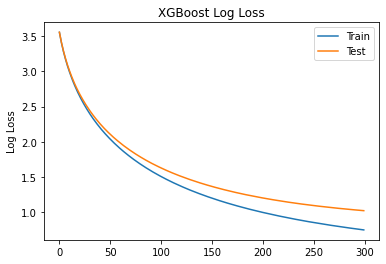

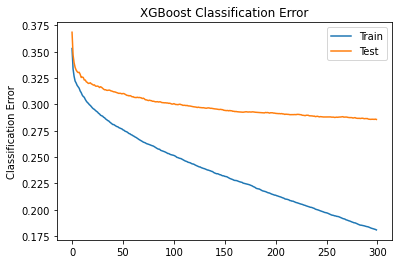

In [ ]:
from matplotlib import pyplot 

results = model2.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

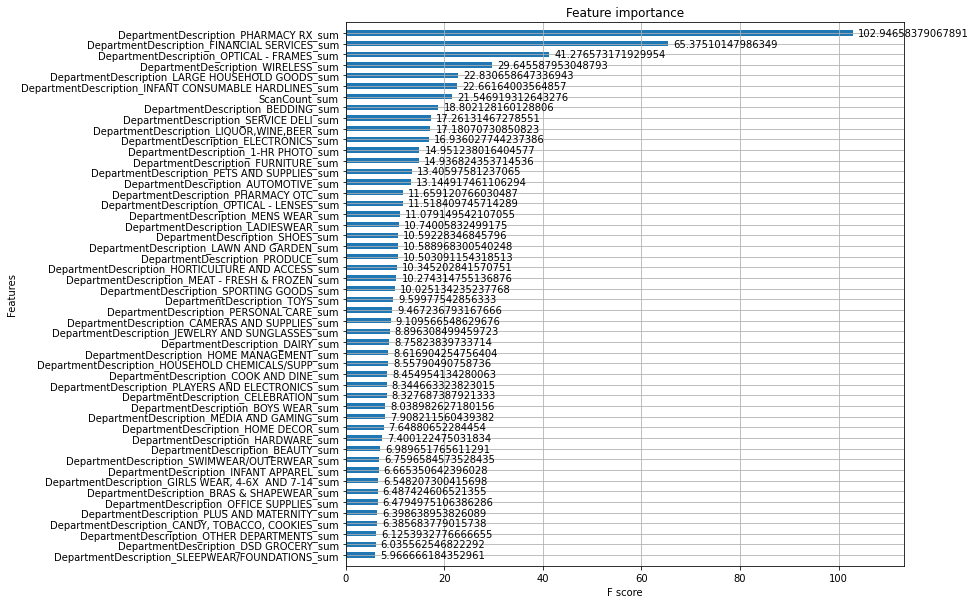

In [ ]:
# Importancia de los features. Vemos los 50 features mas relevantes según nuestro modelo
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model2, max_num_features=50, height=0.5, ax=ax,importance_type='gain')
plt.show()

In [ ]:
kaggle_sub = model2.predict(XX)

In [ ]:
submission = pd.DataFrame(list(zip(XX.index, kaggle_sub)), columns=["VisitNumber", "TripType"])
submission.to_csv("/content/AprendizajeSupervisado/practico/data/submission_xgb1.csv", header=True, index=False)

----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# prediccion para testing
y_pred_tst_rf = vot.predict(XX)

In [ ]:
submission = pd.DataFrame(list(zip(XX.index, y_pred_tst_rf)), columns=["VisitNumber", "TripType"])

In [ ]:
submission.to_csv("/content/drive/My Drive/submission_202009008_113000.csv", 
                  header=True, 
                  index=False)

In [ ]:
#tabla generada
submission

,VisitNumber,TripType
0,7,9
1,8,39
2,15,21
3,19,25
4,23,24
...,...,...
28640,191331,9
28641,191335,32
28642,191342,8
28643,191345,22
